<a href="https://colab.research.google.com/github/chaiminwoo0223/Deep-Learning/blob/main/18%20-%20Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data_Augmentation

- Scale
- Crop
- Flip
- Rotate

# Import

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

# Hyperparameter

In [2]:
batch_size = 256
lr = 0.0002
num_epoch = 10

# Data
## 1.Data Download

In [3]:
mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                              transforms.Resize(34),                      # 28X28 이미지를 34X34 이미지로 늘린다.
                              transforms.CenterCrop(28),                  # 중앙에서 28X28을 뽑아낸다.
                              transforms.RandomHorizontalFlip(),          # 랜덤하게 이미지를 좌우반전 한다.
                              transforms.Lambda(lambda x: x.rotate(90)),  # 람다함수를 이용해, 90도로 회전한다.
                              transforms.ToTensor()                       # 이미지를 텐서로 변환한다.
                         ]), 
                         target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 283460450.83it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 120893906.01it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 181772318.36it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4458349.82it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## 2.Check Dataset

In [4]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000


## 3.Set DataLoader

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

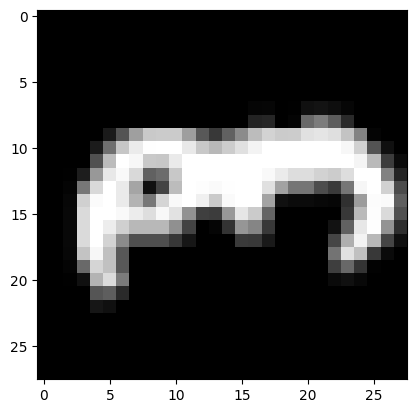

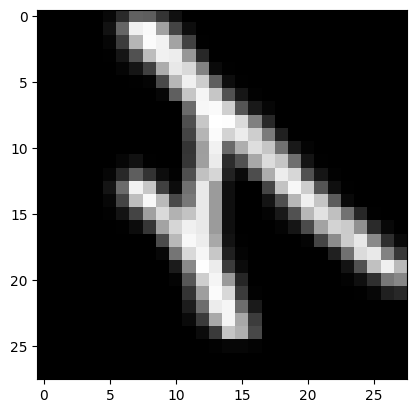

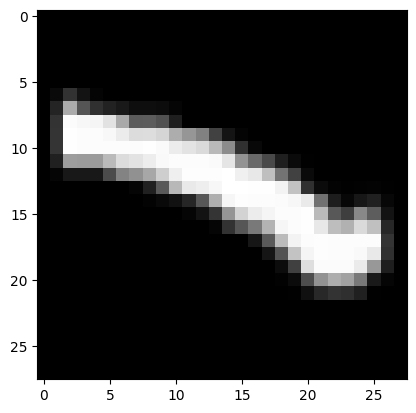

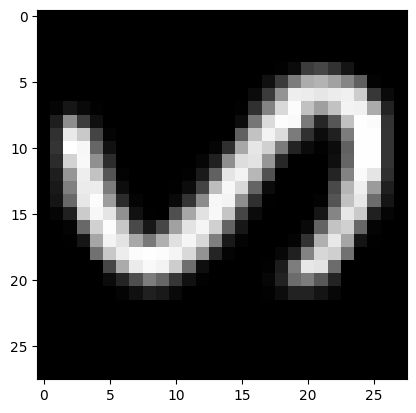

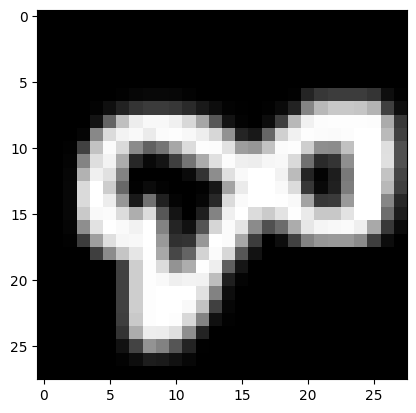

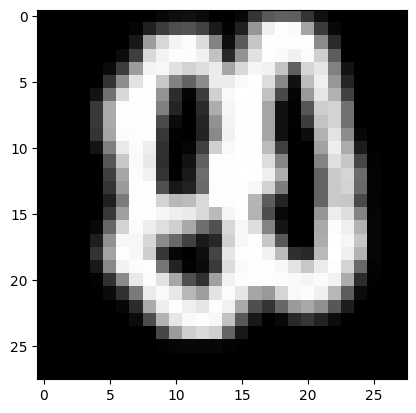

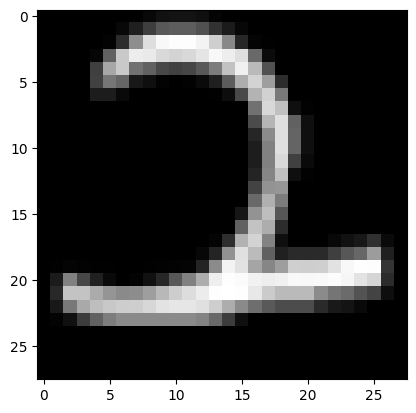

In [6]:
for idx, (img,label) in enumerate(train_loader):
    plt.imshow(img[0,0,], cmap="gray")
    plt.show()
    if idx > 5:
        break

# CNN
## 1.Model

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # 28 X 28
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), # 28 X 28
            nn.ReLU(),
            nn.MaxPool2d(2,2),               # 14 X 14
            nn.Conv2d(32, 64, 3, padding=1), # 14 X 14
            nn.ReLU(),
            nn.MaxPool2d(2,2)                #  7 X 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
    
    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

## 2.Loss_Func & Optimizer

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.1)

In [10]:
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        print(loss)

tensor(2.3044, device='cuda:0', grad_fn=<NllLossBackward0>)


In [11]:
correct = 0
total = 0

with torch.no_grad():
    for image, label in test_loader:
        x = image.to(device)
        y_= label.to(device)
        output = model.forward(x)
        _, output_index = torch.max(output, 1)
        total += label.size(0)                        # 전체 이미지 개수를 저장
        correct += (output_index == y_).sum().float() # 정확하게 분류한 이미지의 개수를 저장
    
    print("Accuracy of Test Data : {}".format(100*correct/total))

Accuracy of Test Data : 9.57532024383545
